In [29]:
!python -V

Python 3.11.8


In [30]:
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [31]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Airline-Flight-Prices-India")

<Experiment: artifact_location='/Users/l.g./Documents/Repo/ml_ops_retail_model_pipeline/model_tracking/mlruns/1', creation_time=1720060282276, experiment_id='1', last_update_time=1720060282276, lifecycle_stage='active', name='Airline-Flight-Prices-India', tags={}>

In [32]:
df = pd.read_csv('../retail_data/flight_dataset.csv')

In [33]:
df.head(n=5)

,Airline,Source,Destination,Total_Stops,Price,Date,Month,Year,Dep_hours,Dep_min,Arrival_hours,Arrival_min,Duration_hours,Duration_min
0,IndiGo,Banglore,New Delhi,0,3897,24,3,2019,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,2019,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,2019,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,2019,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,2019,16,50,21,35,4,45


In [34]:
df.shape

(10683, 14)

In [35]:
df['SO_DE'] = df['Source'] + '_' + df['Destination']

In [36]:
categorical = ['SO_DE'] #['Source', 'Destination']
numerical = ['Duration_hours']

In [37]:
df[categorical] = df[categorical].astype(str)

In [38]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [39]:
dv = DictVectorizer()
X = dv.fit_transform(train_dicts)

In [40]:
target = 'Price'
y = df[target].values

In [41]:
#y_train

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% training, 20% validation

In [43]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [44]:
y_pred = lr.predict(X_val)

/var/folders/tz/tx9cqhzx12d8m9rn6ksgbnhr0000gn/T/ipykernel_71820/1351390157.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/tz/tx9cqhzx12d8m9rn6ksgbnhr0000gn/T/ipykernel_71820/1351390157.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

<Axes: ylabel='Density'>

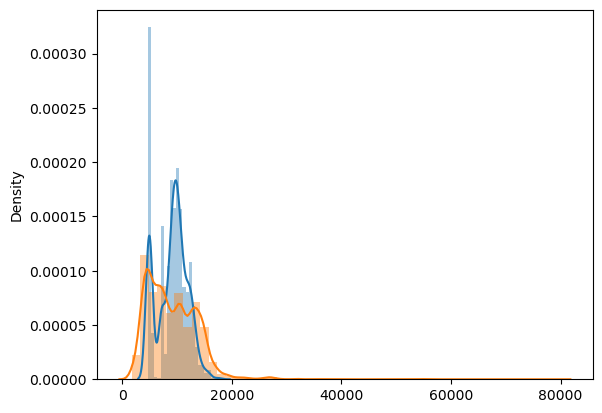

In [45]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

In [46]:
mean_squared_error(y_val, y_pred, squared=False)

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3697.485935178474

In [47]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error on validation set: {rmse}")

Root Mean Squared Error on validation set: 3697.485935178474


In [48]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [49]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Lamar")

    mlflow.log_param("training-data-path", "../retail_data/flight_dataset.csv")
    mlflow.log_param("validation-data-path", "../retail_data/flight_dataset.csv")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    ls = Lasso(alpha)
    ls.fit(X_train, y_train)
    
    y_pred = ls.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

In [50]:
with open('../models/lin_lasso_reg.bin', 'wb') as f_out:
    pickle.dump((dv, ls), f_out)

In [51]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [52]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [53]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=200,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)
        
    return {'loss': rmse, 'status': STATUS_OK}



In [54]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lamdba', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3), 
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials())

[0]	validation-rmse:3644.82322                                                                                                                               
[1]	validation-rmse:3413.29946                                                                                                                               
[2]	validation-rmse:3366.57356                                                                                                                               
[3]	validation-rmse:3359.11389                                                                                                                               
[4]	validation-rmse:3358.84122                                                                                                                               
[5]	validation-rmse:3359.43217                                                                                                                               
[6]	validation-rmse:3359.86004                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:53] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[31]	validation-rmse:3360.32315                                                                                                                              
[32]	validation-rmse:3360.32315                                                                                                                              
[33]	validation-rmse:3360.32315                                                                                                                              
[34]	validation-rmse:3360.32315                                                                                                                              
[35]	validation-rmse:3360.32315                                                                                                                              
[36]	validation-rmse:3360.32315                                                                                                                              
[37]	validation-rmse:3360.32315                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[46]	validation-rmse:3356.19275                                                                                                                              
[47]	validation-rmse:3356.30670                                                                                                                              
[48]	validation-rmse:3356.50981                                                                                                                              
[49]	validation-rmse:3356.34334                                                                                                                              
[50]	validation-rmse:3356.64849                                                                                                                              
[51]	validation-rmse:3356.65284                                                                                                                              
[52]	validation-rmse:3356.53646                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[48]	validation-rmse:3357.41133                                                                                                                              
[49]	validation-rmse:3357.39592                                                                                                                              
[50]	validation-rmse:3357.84332                                                                                                                              
[51]	validation-rmse:3357.49277                                                                                                                              
[52]	validation-rmse:3357.78383                                                                                                                              
[53]	validation-rmse:3358.13035                                                                                                                              
[54]	validation-rmse:3358.03676                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[55]	validation-rmse:3361.58355                                                                                                                              
[56]	validation-rmse:3361.29577                                                                                                                              
[57]	validation-rmse:3361.67377                                                                                                                              
[58]	validation-rmse:3361.95957                                                                                                                              
[59]	validation-rmse:3361.42665                                                                                                                              
[60]	validation-rmse:3361.95539                                                                                                                              
[61]	validation-rmse:3362.16034                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[55]	validation-rmse:3353.38584                                                                                                                              
[56]	validation-rmse:3353.74475                                                                                                                              
[57]	validation-rmse:3354.04890                                                                                                                              
[58]	validation-rmse:3354.11524                                                                                                                              
[59]	validation-rmse:3354.45487                                                                                                                              
[60]	validation-rmse:3354.53363                                                                                                                              
[61]	validation-rmse:3354.86017                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:55] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[35]	validation-rmse:3360.31453                                                                                                                              
[36]	validation-rmse:3360.31661                                                                                                                              
[37]	validation-rmse:3360.31825                                                                                                                              
[38]	validation-rmse:3360.31946                                                                                                                              
[39]	validation-rmse:3360.32042                                                                                                                              
[40]	validation-rmse:3360.32113                                                                                                                              
[41]	validation-rmse:3360.32168                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:55] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[36]	validation-rmse:3360.25475                                                                                                                              
[37]	validation-rmse:3360.26689                                                                                                                              
[38]	validation-rmse:3360.27692                                                                                                                              
[39]	validation-rmse:3360.28469                                                                                                                              
[40]	validation-rmse:3360.29163                                                                                                                              
[41]	validation-rmse:3360.29684                                                                                                                              
[42]	validation-rmse:3360.30156                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:56] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[34]	validation-rmse:3360.24593                                                                                                                              
[35]	validation-rmse:3360.26030                                                                                                                              
[36]	validation-rmse:3360.27214                                                                                                                              
[37]	validation-rmse:3360.28161                                                                                                                              
[38]	validation-rmse:3360.28938                                                                                                                              
[39]	validation-rmse:3360.29590                                                                                                                              
[40]	validation-rmse:3360.30066                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:56] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[53]	validation-rmse:3350.54098                                                                                                                              
[54]	validation-rmse:3350.36900                                                                                                                              
[55]	validation-rmse:3350.28096                                                                                                                              
[56]	validation-rmse:3350.65796                                                                                                                              
[57]	validation-rmse:3351.01802                                                                                                                              
[58]	validation-rmse:3351.17856                                                                                                                              
[59]	validation-rmse:3351.47694                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:56] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[38]	validation-rmse:3359.86018                                                                                                                              
[39]	validation-rmse:3360.39391                                                                                                                              
[40]	validation-rmse:3359.18641                                                                                                                              
[41]	validation-rmse:3359.57138                                                                                                                              
[42]	validation-rmse:3359.80852                                                                                                                              
[43]	validation-rmse:3359.65358                                                                                                                              
[44]	validation-rmse:3359.56058                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:57] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[22]	validation-rmse:3400.20028                                                                                                                              
[23]	validation-rmse:3393.38441                                                                                                                              
[24]	validation-rmse:3387.04082                                                                                                                              
[25]	validation-rmse:3381.72401                                                                                                                              
[26]	validation-rmse:3377.30318                                                                                                                              
[27]	validation-rmse:3373.34065                                                                                                                              
[28]	validation-rmse:3370.08269                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:58] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[34]	validation-rmse:3360.44604                                                                                                                              
[35]	validation-rmse:3360.39032                                                                                                                              
[36]	validation-rmse:3360.57288                                                                                                                              
[37]	validation-rmse:3360.54420                                                                                                                              
[38]	validation-rmse:3360.70129                                                                                                                              
[39]	validation-rmse:3360.70370                                                                                                                              
[40]	validation-rmse:3360.81734                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:58] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[34]	validation-rmse:3357.71114                                                                                                                              
[35]	validation-rmse:3358.43432                                                                                                                              
[36]	validation-rmse:3357.55496                                                                                                                              
[37]	validation-rmse:3358.24548                                                                                                                              
[38]	validation-rmse:3357.99286                                                                                                                              
[39]	validation-rmse:3357.23920                                                                                                                              
[40]	validation-rmse:3357.87628                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:59] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[23]	validation-rmse:3360.17969                                                                                                                              
[24]	validation-rmse:3359.57131                                                                                                                              
[25]	validation-rmse:3359.15624                                                                                                                              
[26]	validation-rmse:3358.89039                                                                                                                              
[27]	validation-rmse:3358.73126                                                                                                                              
[28]	validation-rmse:3358.65360                                                                                                                              
[29]	validation-rmse:3358.63541                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:59] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[24]	validation-rmse:3392.56893                                                                                                                              
[25]	validation-rmse:3387.32000                                                                                                                              
[26]	validation-rmse:3382.81251                                                                                                                              
[27]	validation-rmse:3378.94821                                                                                                                              
[28]	validation-rmse:3375.64486                                                                                                                              
[29]	validation-rmse:3372.82045                                                                                                                              
[30]	validation-rmse:3370.41346                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:00] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[43]	validation-rmse:3364.15179                                                                                                                              
[44]	validation-rmse:3363.23409                                                                                                                              
[45]	validation-rmse:3362.32297                                                                                                                              
[46]	validation-rmse:3361.64185                                                                                                                              
[47]	validation-rmse:3360.93463                                                                                                                              
[48]	validation-rmse:3360.43857                                                                                                                              
[49]	validation-rmse:3359.90033                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:01] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[41]	validation-rmse:3359.60237
[42]	validation-rmse:3359.14483                                                                                                                              
[43]	validation-rmse:3359.53530                                                                                                                              
[44]	validation-rmse:3359.36267                                                                                                                              
[45]	validation-rmse:3360.05157                                                                                                                              
[46]	validation-rmse:3359.95339                                                                                                                              
[47]	validation-rmse:3359.51294                                                                                                                              
[48]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:01] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[40]	validation-rmse:3354.79874                                                                                                                              
[41]	validation-rmse:3354.68482                                                                                                                              
[42]	validation-rmse:3354.97473                                                                                                                              
[43]	validation-rmse:3354.93389                                                                                                                              
[44]	validation-rmse:3355.20705                                                                                                                              
[45]	validation-rmse:3354.89687                                                                                                                              
[46]	validation-rmse:3354.64421                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:02] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[27]	validation-rmse:3358.34323                                                                                                                              
[28]	validation-rmse:3358.53160                                                                                                                              
[29]	validation-rmse:3358.79239                                                                                                                              
[30]	validation-rmse:3358.93893                                                                                                                              
[31]	validation-rmse:3359.17398                                                                                                                              
[32]	validation-rmse:3359.39461                                                                                                                              
[33]	validation-rmse:3359.60627                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:02] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[40]	validation-rmse:3363.82585                                                                                                                              
[41]	validation-rmse:3362.96139                                                                                                                              
[42]	validation-rmse:3362.90264                                                                                                                              
[43]	validation-rmse:3363.38135                                                                                                                              
[44]	validation-rmse:3362.63897                                                                                                                              
[45]	validation-rmse:3362.47742                                                                                                                              
[46]	validation-rmse:3362.55892                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[74]	validation-rmse:3343.56702                                                                                                                              
[75]	validation-rmse:3343.49459                                                                                                                              
[76]	validation-rmse:3342.98582                                                                                                                              
[77]	validation-rmse:3342.50116                                                                                                                              
[78]	validation-rmse:3342.07453                                                                                                                              
[79]	validation-rmse:3341.71972                                                                                                                              
[80]	validation-rmse:3341.49136                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:3359.67829                                                                                                                              
[48]	validation-rmse:3359.07778                                                                                                                              
[49]	validation-rmse:3358.52813                                                                                                                              
[50]	validation-rmse:3358.06321                                                                                                                              
[51]	validation-rmse:3357.60573                                                                                                                              
[52]	validation-rmse:3357.28765                                                                                                                              
[53]	validation-rmse:3356.92821                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:04] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:3890.29458                                                                                                                               
[1]	validation-rmse:3572.00820                                                                                                                               
[2]	validation-rmse:3439.98220                                                                                                                               
[3]	validation-rmse:3385.67656                                                                                                                               
[4]	validation-rmse:3366.45279                                                                                                                               
[5]	validation-rmse:3357.79157                                                                                                                               
[6]	validation-rmse:3356.34113                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:04] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[44]	validation-rmse:3360.08058                                                                                                                              
[45]	validation-rmse:3360.36677                                                                                                                              
[46]	validation-rmse:3360.37716                                                                                                                              
[47]	validation-rmse:3360.97245                                                                                                                              
[48]	validation-rmse:3361.10380                                                                                                                              
[49]	validation-rmse:3360.56838                                                                                                                              
[50]	validation-rmse:3360.69692                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:04] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:04] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:3371.86703                                                                                                                               
[5]	validation-rmse:3363.90523                                                                                                                               
[6]	validation-rmse:3361.28234                                                                                                                               
[7]	validation-rmse:3360.31948                                                                                                                               
[8]	validation-rmse:3358.92662                                                                                                                               
[9]	validation-rmse:3360.73010                                                                                                                               
[10]	validation-rmse:3360.61091                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:3364.28058                                                                                                                              
[48]	validation-rmse:3364.27831                                                                                                                              
[49]	validation-rmse:3364.23204                                                                                                                              
[50]	validation-rmse:3364.37369                                                                                                                              
[51]	validation-rmse:3364.35043                                                                                                                              
[52]	validation-rmse:3364.31530                                                                                                                              
[0]	validation-rmse:3965.89509                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[41]	validation-rmse:3349.99074
[42]	validation-rmse:3349.93075                                                                                                                              
[43]	validation-rmse:3349.86975                                                                                                                              
[44]	validation-rmse:3349.85556                                                                                                                              
[45]	validation-rmse:3350.43146                                                                                                                              
[46]	validation-rmse:3350.38381                                                                                                                              
[47]	validation-rmse:3351.06545                                                                                                                              
[48]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[38]	validation-rmse:3360.32295                                                                                                                              
[39]	validation-rmse:3360.32295                                                                                                                              
[40]	validation-rmse:3360.32295                                                                                                                              
[41]	validation-rmse:3360.32295                                                                                                                              
[42]	validation-rmse:3360.32295                                                                                                                              
[43]	validation-rmse:3360.32295                                                                                                                              
[44]	validation-rmse:3360.32295                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:06] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:3356.20096                                                                                                                              
[48]	validation-rmse:3356.23480                                                                                                                              
[49]	validation-rmse:3356.09287                                                                                                                              
[50]	validation-rmse:3356.40141                                                                                                                              
[51]	validation-rmse:3356.28655                                                                                                                              
[52]	validation-rmse:3356.53415                                                                                                                              
[53]	validation-rmse:3356.45840                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:06] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[38]	validation-rmse:3362.42080                                                                                                                              
[39]	validation-rmse:3362.43322                                                                                                                              
[40]	validation-rmse:3362.43467                                                                                                                              
[41]	validation-rmse:3362.44225                                                                                                                              
[42]	validation-rmse:3362.44335                                                                                                                              
[43]	validation-rmse:3362.44914                                                                                                                              
[44]	validation-rmse:3362.44890                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:06] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[44]	validation-rmse:3359.68030                                                                                                                              
[45]	validation-rmse:3359.91605                                                                                                                              
[46]	validation-rmse:3359.76346                                                                                                                              
[47]	validation-rmse:3359.83963                                                                                                                              
[48]	validation-rmse:3359.80002                                                                                                                              
[49]	validation-rmse:3359.99861                                                                                                                              
[50]	validation-rmse:3360.00094                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[33]	validation-rmse:3361.29508                                                                                                                              
[34]	validation-rmse:3361.23436                                                                                                                              
[35]	validation-rmse:3361.40144                                                                                                                              
[36]	validation-rmse:3361.35694                                                                                                                              
[37]	validation-rmse:3361.51559                                                                                                                              
[38]	validation-rmse:3361.46234                                                                                                                              
[39]	validation-rmse:3361.58976                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[50]	validation-rmse:3354.62074                                                                                                                              
[51]	validation-rmse:3354.62076                                                                                                                              
[52]	validation-rmse:3354.62076                                                                                                                              
[53]	validation-rmse:3354.62077                                                                                                                              
[54]	validation-rmse:3354.62077                                                                                                                              
[55]	validation-rmse:3354.62080                                                                                                                              
[0]	validation-rmse:4317.64256                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[40]	validation-rmse:3359.96163                                                                                                                              
[41]	validation-rmse:3360.04426                                                                                                                              
[42]	validation-rmse:3360.69350                                                                                                                              
[43]	validation-rmse:3360.84889                                                                                                                              
[44]	validation-rmse:3361.44284                                                                                                                              
[45]	validation-rmse:3361.92178                                                                                                                              
[46]	validation-rmse:3361.04592                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[45]	validation-rmse:3360.20466
[46]	validation-rmse:3359.64465                                                                                                                              
[47]	validation-rmse:3359.89650                                                                                                                              
[48]	validation-rmse:3360.55403                                                                                                                              
[49]	validation-rmse:3359.05915                                                                                                                              
[50]	validation-rmse:3360.03741                                                                                                                              
[51]	validation-rmse:3359.77581                                                                                                                              
[0]	validation-rmse:

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[41]	validation-rmse:3355.87043
[42]	validation-rmse:3355.97816                                                                                                                              
[43]	validation-rmse:3356.05795                                                                                                                              
[44]	validation-rmse:3355.84175                                                                                                                              
[45]	validation-rmse:3356.24144                                                                                                                              
[46]	validation-rmse:3355.95732                                                                                                                              
[47]	validation-rmse:3356.21392                                                                                                                              
[48]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[40]	validation-rmse:3358.14215                                                                                                                              
[41]	validation-rmse:3357.91942                                                                                                                              
[42]	validation-rmse:3357.74511                                                                                                                              
[43]	validation-rmse:3358.12663                                                                                                                              
[44]	validation-rmse:3357.76999                                                                                                                              
[45]	validation-rmse:3358.23094                                                                                                                              
[46]	validation-rmse:3358.58258                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:09] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[41]	validation-rmse:3361.69068                                                                                                                              
[42]	validation-rmse:3361.67627                                                                                                                              
[43]	validation-rmse:3361.77058                                                                                                                              
[44]	validation-rmse:3361.75040                                                                                                                              
[45]	validation-rmse:3361.83209                                                                                                                              
[46]	validation-rmse:3361.82633                                                                                                                              
[47]	validation-rmse:3361.88207                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:09] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4320.51649                                                                                                                               
[1]	validation-rmse:4096.83743                                                                                                                               
[2]	validation-rmse:3921.04662                                                                                                                               
[3]	validation-rmse:3783.90284                                                                                                                               
[4]	validation-rmse:3677.39940                                                                                                                               
[5]	validation-rmse:3595.59448                                                                                                                               
[6]	validation-rmse:3533.42567                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:09] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[46]	validation-rmse:3359.97797
[47]	validation-rmse:3360.19885                                                                                                                              
[48]	validation-rmse:3360.08381                                                                                                                              
[49]	validation-rmse:3360.26149                                                                                                                              
[50]	validation-rmse:3359.30564                                                                                                                              
[51]	validation-rmse:3359.52815                                                                                                                              
[52]	validation-rmse:3359.72495                                                                                                                              
[53]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:10] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[43]	validation-rmse:3355.93297                                                                                                                              
[44]	validation-rmse:3356.03205                                                                                                                              
[45]	validation-rmse:3356.43006                                                                                                                              
[46]	validation-rmse:3356.14433                                                                                                                              
[47]	validation-rmse:3356.43386                                                                                                                              
[48]	validation-rmse:3356.32050                                                                                                                              
[49]	validation-rmse:3356.52746                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:10] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[39]	validation-rmse:3356.44739
[40]	validation-rmse:3356.86505                                                                                                                              
[41]	validation-rmse:3356.40368                                                                                                                              
[42]	validation-rmse:3356.05325                                                                                                                              
[43]	validation-rmse:3356.87785                                                                                                                              
[44]	validation-rmse:3356.45847                                                                                                                              
[45]	validation-rmse:3356.38677                                                                                                                              
[46]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:10] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[48]	validation-rmse:3359.70369                                                                                                                              
[49]	validation-rmse:3360.55717                                                                                                                              
[50]	validation-rmse:3360.21061                                                                                                                              
[51]	validation-rmse:3359.82533                                                                                                                              
[52]	validation-rmse:3359.50980                                                                                                                              
[53]	validation-rmse:3359.27610                                                                                                                              
[54]	validation-rmse:3359.27426                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:11] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[43]	validation-rmse:3361.77722                                                                                                                              
[44]	validation-rmse:3361.19496                                                                                                                              
[45]	validation-rmse:3360.70039                                                                                                                              
[46]	validation-rmse:3360.28261                                                                                                                              
[47]	validation-rmse:3359.93343                                                                                                                              
[48]	validation-rmse:3359.64123                                                                                                                              
[49]	validation-rmse:3359.40002                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:11] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[44]	validation-rmse:3352.70660                                                                                                                              
[45]	validation-rmse:3353.27452                                                                                                                              
[46]	validation-rmse:3353.31159                                                                                                                              
[47]	validation-rmse:3353.85697                                                                                                                              
[48]	validation-rmse:3353.95716                                                                                                                              
[49]	validation-rmse:3354.47103                                                                                                                              
[50]	validation-rmse:3354.58338                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:12] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[44]	validation-rmse:3354.08804                                                                                                                              
[45]	validation-rmse:3353.70599                                                                                                                              
[46]	validation-rmse:3353.35693                                                                                                                              
[47]	validation-rmse:3353.08222                                                                                                                              
[48]	validation-rmse:3352.83333                                                                                                                              
[49]	validation-rmse:3352.64305                                                                                                                              
[50]	validation-rmse:3352.77037                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:12] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[38]	validation-rmse:3357.53398                                                                                                                              
[39]	validation-rmse:3357.51821                                                                                                                              
[40]	validation-rmse:3357.39871                                                                                                                              
[41]	validation-rmse:3357.45976                                                                                                                              
[42]	validation-rmse:3357.41582                                                                                                                              
[43]	validation-rmse:3357.42307                                                                                                                              
[44]	validation-rmse:3357.44017                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:13] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[23]	validation-rmse:3362.03796                                                                                                                              
[24]	validation-rmse:3362.29189                                                                                                                              
[25]	validation-rmse:3362.30718                                                                                                                              
[26]	validation-rmse:3362.57697                                                                                                                              
[27]	validation-rmse:3363.43403                                                                                                                              
[28]	validation-rmse:3363.59170                                                                                                                              
[29]	validation-rmse:3364.25530                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:13] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[41]	validation-rmse:3359.95214
[42]	validation-rmse:3359.95251                                                                                                                              
[43]	validation-rmse:3359.95250                                                                                                                              
[44]	validation-rmse:3359.95250                                                                                                                              
[45]	validation-rmse:3359.95253                                                                                                                              
[46]	validation-rmse:3359.95258                                                                                                                              
[47]	validation-rmse:3359.95187                                                                                                                              
[48]	validation-rmse

In [ ]:
params = {
'learning_rate': 0.05059823075449685,
'max_depth': 4,
'min_child_weight':5.008520794187583,
'objective':'reg:linear',
'reg_alpha':0.07415085063191965,
'reg_lambda':0.11333795232359768,
'seed':42
}

In [ ]:
booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=200,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
        )